In [49]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [50]:
def getWineDataSet():
    voteData = pd.read_csv("datasets\hw3_wine.csv", sep='\t')
    columns = voteData.columns.tolist()
    new_order = columns[1:] + [columns[0]]
    voteData = voteData[new_order]
    return voteData

In [51]:
def getHouseVoteDataset():
    voteData = pd.read_csv("datasets\hw3_house_votes_84.csv")
    return voteData

In [52]:
def getCancerDataset():
    voteData = pd.read_csv("datasets\hw3_cancer.csv", sep='\t')
    return voteData

In [53]:
def getContraceptiveDataSet():
    voteData = pd.read_csv("datasets\contraceptive+method+choice\cmc.data", sep='\t')
    return voteData

In [54]:
def splitDataset(dataset):
    feature = dataset.values[:, :-1]
    label = dataset.values[:, -1]
    feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.2)
    return feature_train, feature_test, label_train, label_test

In [55]:
class Node:
    def __init__(self, featureName=None, threshold=None, value=None, children=None, majorityLabel=None):
        self.featureName = featureName
        self.threshold = threshold
        self.value = value
        self.children = children or {}
        self.majorityLabel = majorityLabel

In [56]:
def calculateEntropy(labels):
    numClasses = Counter(labels)
    entropy = 0
    instanceCount = len(labels)
    for count in numClasses.values():
        probability = count / instanceCount
        entropy -= probability * np.log2(probability)
    return entropy

In [57]:
def calculateGini(labels):
    class_counts = Counter(labels)
    instances = len(labels)
    impurity = 1 - sum((count / instances) ** 2 for count in class_counts.values())
    return impurity


In [58]:
def calculateInfoGain(dataset, partitions):
    netDatasetEntropy = calculateEntropy(dataset[:, -1])
    return netDatasetEntropy - sum([(len(partition) / len(dataset)) * calculateEntropy(partition[:, -1]) for partition in partitions])

In [59]:
def calculateWeightedGini(partitions, dataset):
    total_instances = len(dataset)
    weighted_gini = sum((len(partition) / total_instances) * calculateGini(partition[:, -1]) for partition in partitions)
    return weighted_gini

In [60]:
def bootstrap_sample(dataset):
    n_samples = len(dataset)
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return dataset.iloc[indices]

In [61]:
def selectAttribute(dataset, attributeList, attributeNames, criterion='infoGain'):
    bestMeasure = float("inf") if criterion == 'giniIndex' else float("-inf")
    bestAttributeIdx = None
    bestThreshold = None
    bestGain = 0

    m = int(np.sqrt(len(attributeList)))
    sampledAttributeList = np.random.choice(attributeList, size=m, replace=False)

    for attributeIdx in sampledAttributeList:
        columnData = dataset[:, attributeIdx]
        uniqueValues = np.unique(columnData)
        is_numeric = np.issubdtype(columnData.dtype, np.number)

        for value in uniqueValues:
            if is_numeric:
                less = dataset[columnData <= value]
                greater = dataset[columnData > value]
            else:
                less = dataset[columnData == value]
                greater = dataset[columnData != value]
                
            partitions = [less, greater]

            if criterion == 'infoGain':
                measure = calculateInfoGain(dataset, partitions)
            elif criterion == 'giniIndex':
                measure = calculateWeightedGini(partitions, dataset)
            else:
                raise ValueError("Invalid criterion")

            if (criterion == 'infoGain' and measure > bestMeasure) or (criterion == 'giniIndex' and measure < bestMeasure):
                bestMeasure = measure
                bestAttributeIdx = attributeIdx
                bestThreshold = value if is_numeric else None
                bestGain = measure

    attributeNames = list(attributeNames)
    return bestAttributeIdx, attributeNames[bestAttributeIdx], bestThreshold, bestGain


In [62]:
def buildDecisionTree(dataset, attributeList, attributeNames, criterion='infoGain', depth=0, min_size=2, max_depth=7, min_gain=0.0001):

    majority_label = Counter(dataset[:, -1]).most_common(1)[0][0]
    
    if len(dataset) == 0 or len(set(dataset[:, -1])) == 1:
        return Node(value=majority_label, majorityLabel=majority_label)
    if len(dataset) < min_size or depth >= max_depth or len(attributeList) == 0:
        return Node(value=majority_label, majorityLabel=majority_label)

    bestAttributeIdx, bestAttributeName, bestThreshold, gain = selectAttribute(dataset, attributeList, attributeNames, criterion)

    if gain <= min_gain:
        return Node(value=majority_label, majorityLabel=majority_label)

    node = Node(featureName=bestAttributeName, threshold=bestThreshold, majorityLabel=majority_label)

    # Recursively build the tree
    if bestThreshold is not None:
        left_partition = dataset[dataset[:, bestAttributeIdx] <= bestThreshold]
        right_partition = dataset[dataset[:, bestAttributeIdx] > bestThreshold]
        if len(left_partition) > 0:
            node.children['<='] = buildDecisionTree(left_partition, attributeList, attributeNames, criterion, depth+1, min_size, max_depth, min_gain)
        if len(right_partition) > 0:
            node.children['>'] = buildDecisionTree(right_partition, attributeList, attributeNames, criterion, depth+1, min_size, max_depth, min_gain)
    else:
        for value in np.unique(dataset[:, bestAttributeIdx]):
            partition = dataset[dataset[:, bestAttributeIdx] == value]
            if len(partition) > 0:
                node.children[value] = buildDecisionTree(partition, attributeList, attributeNames, criterion, depth+1, min_size, max_depth, min_gain)

    return node



In [63]:
def predictLabel(node, instance, attributeNames):
    if node.value is not None:
        return node.value

    attributeIdx = attributeNames.index(node.featureName)
    attributeValue = instance[attributeIdx]

    if node.threshold is not None:  # It's a numerical attribute
        if attributeValue <= node.threshold:
            child_key = '<='
        else:
            child_key = '>'
    else:  # It's a categorical attribute
        child_key = attributeValue

    if child_key in node.children:
        return predictLabel(node.children[child_key], instance, attributeNames)
    else:
        return node.majorityLabel

In [64]:
def calculateAccuracy(tree, features, labels, attributeNames):
    accuracyCount = 0
    for instance, originalLabel in zip(features, labels):
        observedLabel = predictLabel(tree, instance, attributeNames)
        if observedLabel == originalLabel:
            accuracyCount += 1
    accuracy = accuracyCount / len(labels)
    return accuracy

In [65]:
class RandomForest:
    def __init__(self, n_trees=10, criterion='infoGain', min_size=2, max_depth=7, min_gain=0.0001):
        self.n_trees = n_trees
        self.criterion = criterion
        self.min_size = min_size
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.trees = []
        self.attributeNames = None

    def fit(self, features, target, attributeNames):
        self.attributeNames = attributeNames
        for _ in range(self.n_trees):
            sample_indices = np.random.choice(np.arange(len(features)), size=len(features), replace=True)
            sample_features = features[sample_indices]
            sample_target = target[sample_indices]
            tree = buildDecisionTree(np.column_stack((sample_features, sample_target)), list(range(len(attributeNames))), attributeNames, self.criterion, 0, self.min_size, self.max_depth, self.min_gain)
            self.trees.append(tree)

    def predict(self, instance):
        predictions = [predictLabel(tree, instance, self.attributeNames) for tree in self.trees]
        return Counter(predictions).most_common(1)[0][0]


In [66]:
def custom_stratified_kfold(X, y, n_splits=10):

    X, y = shuffle(X, y)
    folds = [[] for _ in range(n_splits)]
    
    # Get the indices for each class
    class_indices = {cls: np.where(y == cls)[0] for cls in np.unique(y)}
    
    # Distribute the indices of each class approximately equally to each fold
    for cls, indices in class_indices.items():
        np.random.shuffle(indices)
        for i, idx in enumerate(indices):
            folds[i % n_splits].append(idx)
    
    return folds

In [67]:
def calculate_metrics(predictions, actual):
    unique_labels = np.unique(np.concatenate([predictions, actual]))
    accuracy = np.mean(predictions == actual)
    
    precision_list = []
    recall_list = []
    for label in unique_labels:
        tp = np.sum((predictions == label) & (actual == label))
        fp = np.sum((predictions == label) & (actual != label))
        fn = np.sum((predictions != label) & (actual == label))
        tn = np.sum((predictions != label) & (actual != label))

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

    return accuracy, precision, recall, f1


In [68]:
def cross_validate_random_forest(dataset, n_trees, n_splits=10, criterion='infoGain'):
    accuracies, precisions, recalls, f1scores = [], [], [], []


    data_array = dataset.to_numpy() if isinstance(dataset, pd.DataFrame) else dataset

    X = data_array[:, :-1]
    y = data_array[:, -1]

    folds = custom_stratified_kfold(X, y, n_splits=n_splits)

    for i in range(n_splits):
        train_indices = [idx for j, fold in enumerate(folds) if j != i for idx in fold]
        test_indices = folds[i]

        train_X, train_y = X[train_indices], y[train_indices]
        test_X, test_y = X[test_indices], y[test_indices]

        forest = RandomForest(n_trees=n_trees, criterion=criterion)
        attributeNames = list(range(X.shape[1]))  # Use column indices as attribute names
        forest.fit(train_X, train_y, attributeNames)

        predictions = np.array([forest.predict(instance) for instance in test_X])
        accuracy, precision, recall, f1 = calculate_metrics(predictions, test_y)
        
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1scores.append(f1)

    return np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1scores)

In [69]:
def print_metrics(accuracy, precision, recall, f1score, ntree):
    print("************NTree {}************\n".format(ntree))
    print("Accuracy: {}\n".format(accuracy))
    print("Precision: {}\n".format(precision))
    print("Recall: {}\n".format(recall))
    print("F1Score: {}\n".format(f1score))

In [70]:
def plot_metrics(ntree_list, accuracies, precisions, recalls, f1scores, dname, criterion):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(ntree_list, accuracies, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest Accuracy vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(ntree_list, precisions, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest Precision vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('Precision')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(ntree_list, recalls, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest Recall vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('Recall')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(ntree_list, f1scores, marker='o', linestyle='-')
    plt.title('{} Dataset using {} criterion Random Forest F1 Score vs Number of Trees'.format(dname, criterion))
    plt.xlabel('Number of Trees (ntree)')
    plt.ylabel('F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [71]:
def startAlgo(voteData, dname, criterion='infoGain'):
    ntree_list = [1,5,10,20,30,40,50]
    n_splits = 10
    accuracies, precisions, recalls, f1scores = [], [], [], []
    print("########################### {} DataSet using {} criterion ###########################\n".format(dname, criterion))
    for ntree in ntree_list:
        accuracy, precision, recall, f1score = cross_validate_random_forest(voteData, ntree, n_splits, criterion)
        print_metrics(accuracy, precision, recall, f1score, ntree)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1scores.append(f1score)

    plot_metrics(ntree_list, accuracies, precisions, recalls, f1scores, dname, criterion)

########################### Wine DataSet using infoGain criterion ###########################



************NTree 1************

Accuracy: 0.8926535087719298

Precision: 0.9114947089947091

Recall: 0.8897354497354497

F1Score: 0.9001812029736567

************NTree 5************

Accuracy: 0.9604166666666668

Precision: 0.9623280423280424

Recall: 0.9633333333333335

F1Score: 0.9627994319256062

************NTree 10************

Accuracy: 0.9604575163398692

Precision: 0.9629761904761907

Recall: 0.9612698412698414

F1Score: 0.9621048356919186

************NTree 20************

Accuracy: 0.9776681286549707

Precision: 0.9785714285714286

Recall: 0.9830687830687831

F1Score: 0.9807605411426635

************NTree 30************

Accuracy: 0.9833333333333332

Precision: 0.986111111111111

Recall: 0.981111111111111

F1Score: 0.983578071463534

************NTree 40************

Accuracy: 0.9888888888888889

Precision: 0.9907407407407408

Recall: 0.9902777777777778

F1Score: 0.9904952007496123

************NTree 50************

Accuracy: 0.9888888888888889

Precision: 0.9902777777777778

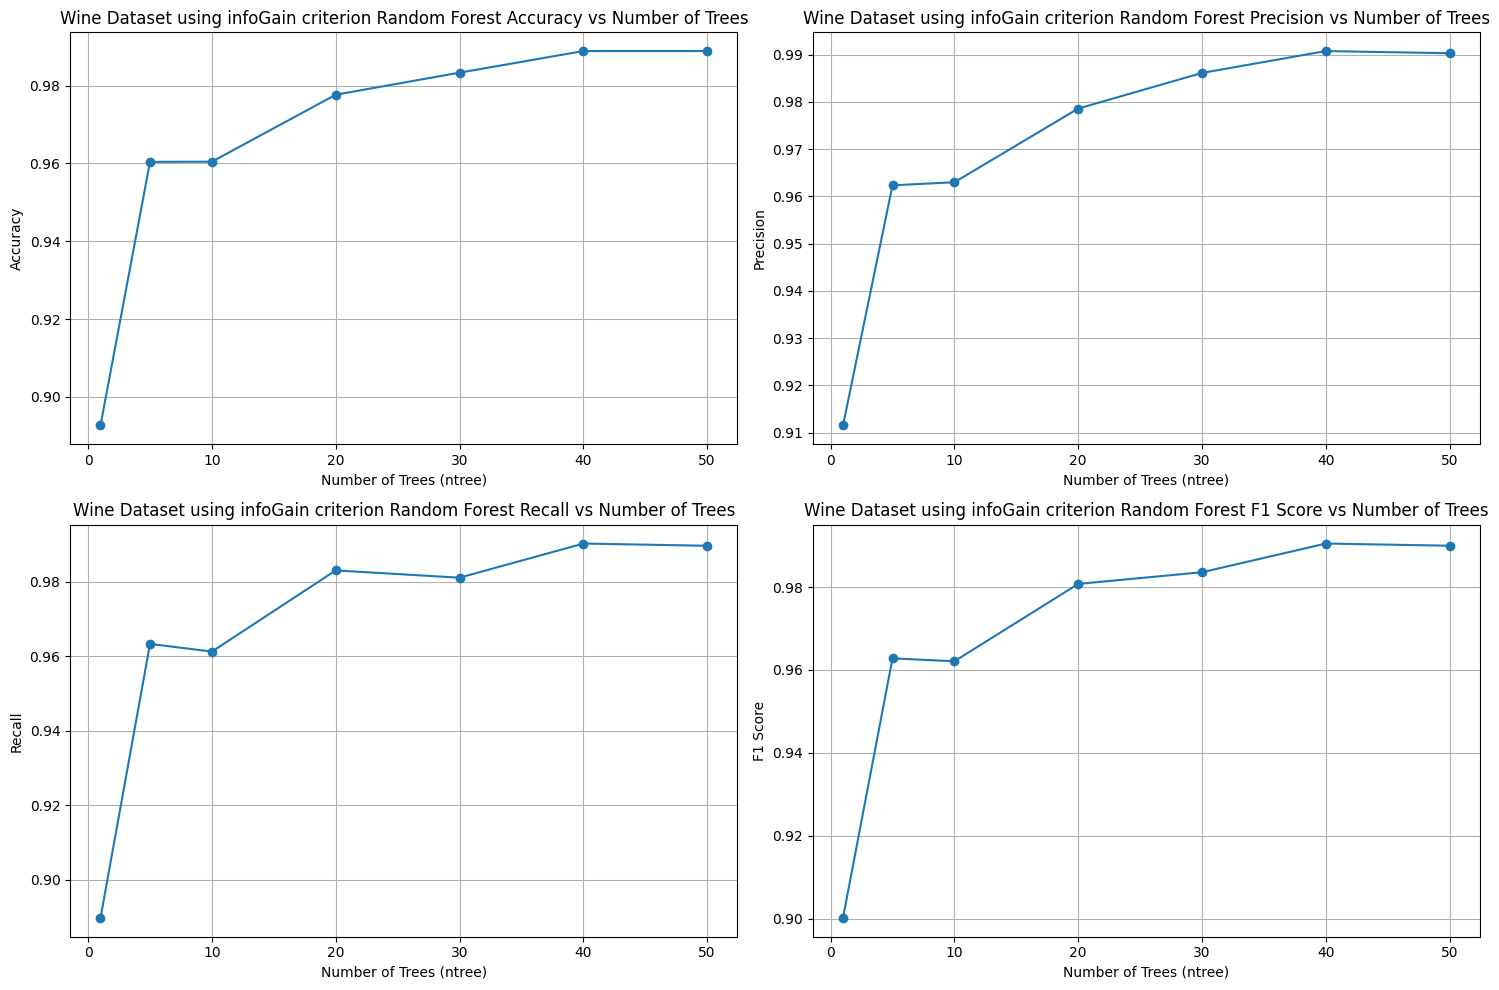

########################### House_Votes_84 DataSet using infoGain criterion ###########################

************NTree 1************

Accuracy: 0.9331193999798651

Precision: 0.9331256529828111

Recall: 0.9253445082633857

F1Score: 0.9290676179344726

************NTree 5************

Accuracy: 0.9539539917446895

Precision: 0.9488957773965515

Recall: 0.9563656760839958

F1Score: 0.9525715488823199

************NTree 10************

Accuracy: 0.9564406523708848

Precision: 0.9536364287058712

Recall: 0.9546871580416173

F1Score: 0.9541104118855201

************NTree 20************

Accuracy: 0.9563903151112454

Precision: 0.9523840934924696

Recall: 0.9578301243869195

F1Score: 0.9549591431841554

************NTree 30************

Accuracy: 0.9584415584415584

Precision: 0.9545901034952893

Recall: 0.9581198654000513

F1Score: 0.956337536844549

************NTree 40************

Accuracy: 0.9609332527937179

Precision: 0.9578487233861022

Recall: 0.9621038713701757

F1Score: 0.9599

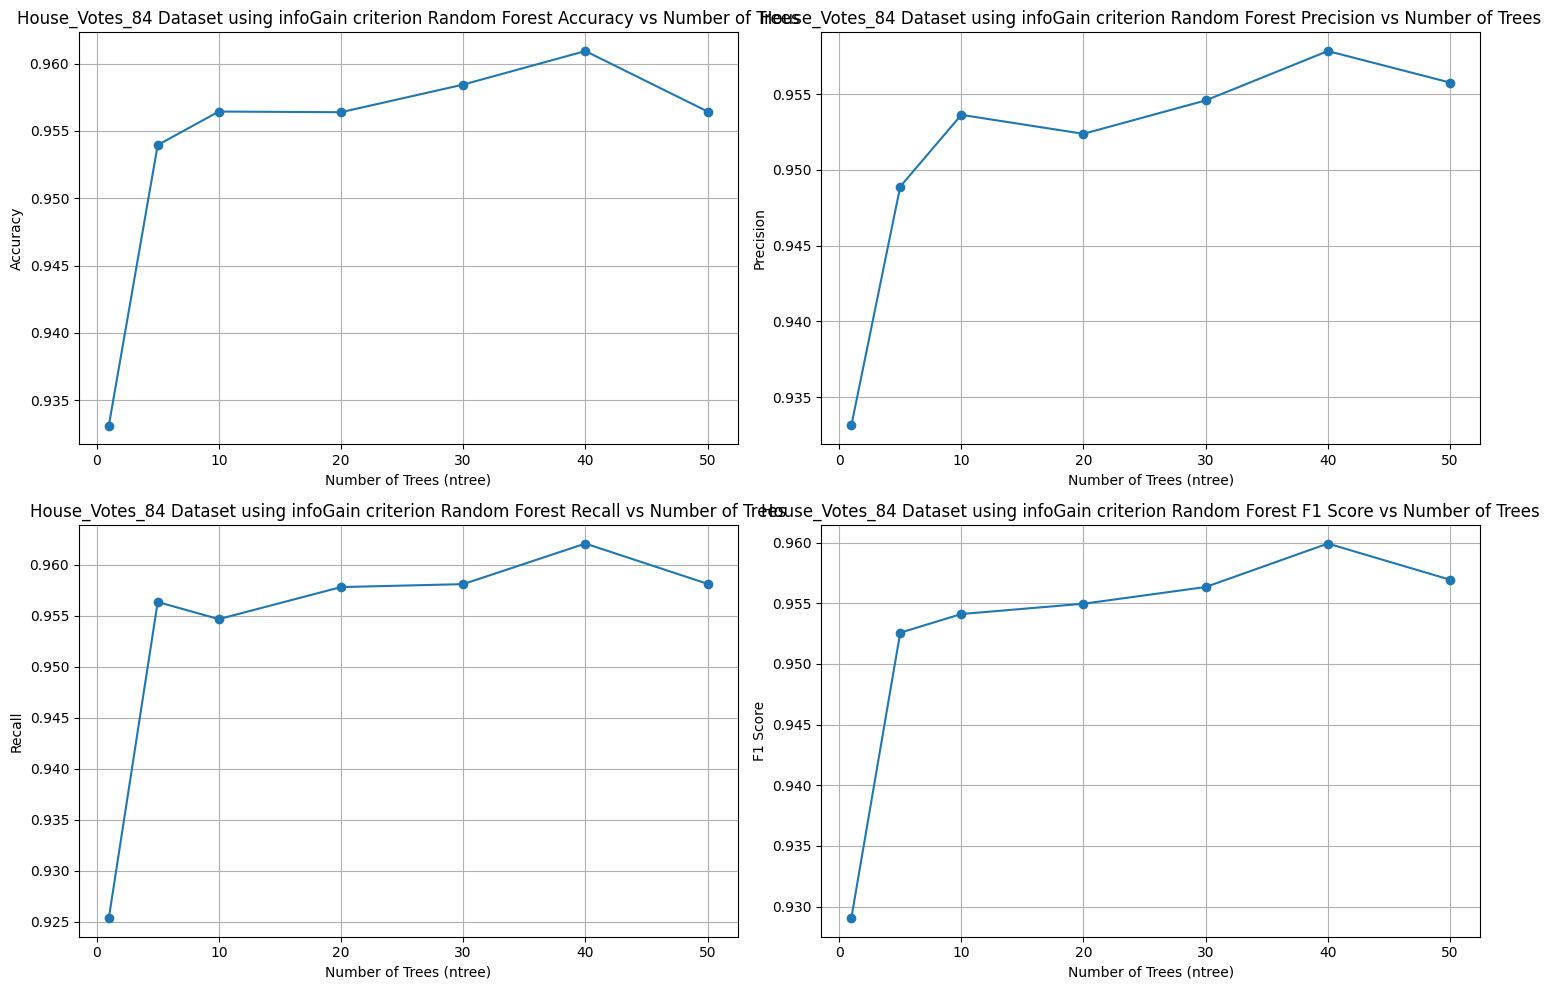

########################### Wine DataSet using giniIndex criterion ###########################

************NTree 1************

Accuracy: 0.8071271929824562

Precision: 0.8251322751322752

Recall: 0.8011327561327561

F1Score: 0.8097455641446321

************NTree 5************

Accuracy: 0.9614035087719298

Precision: 0.9629761904761904

Recall: 0.968425925925926

F1Score: 0.9656699434405113

************NTree 10************

Accuracy: 0.9444100447196423

Precision: 0.9307142857142857

Recall: 0.9568903318903319

F1Score: 0.9432826003295649

************NTree 20************

Accuracy: 0.9485767113863088

Precision: 0.9476455026455026

Recall: 0.9611772486772485

F1Score: 0.9542759546950126

************NTree 30************

Accuracy: 0.9666666666666666

Precision: 0.9479629629629629

Recall: 0.9706481481481483

F1Score: 0.9587201907224674

************NTree 40************

Accuracy: 0.9534378224974199

Precision: 0.9454761904761906

Recall: 0.963399470899471

F1Score: 0.95417241192491

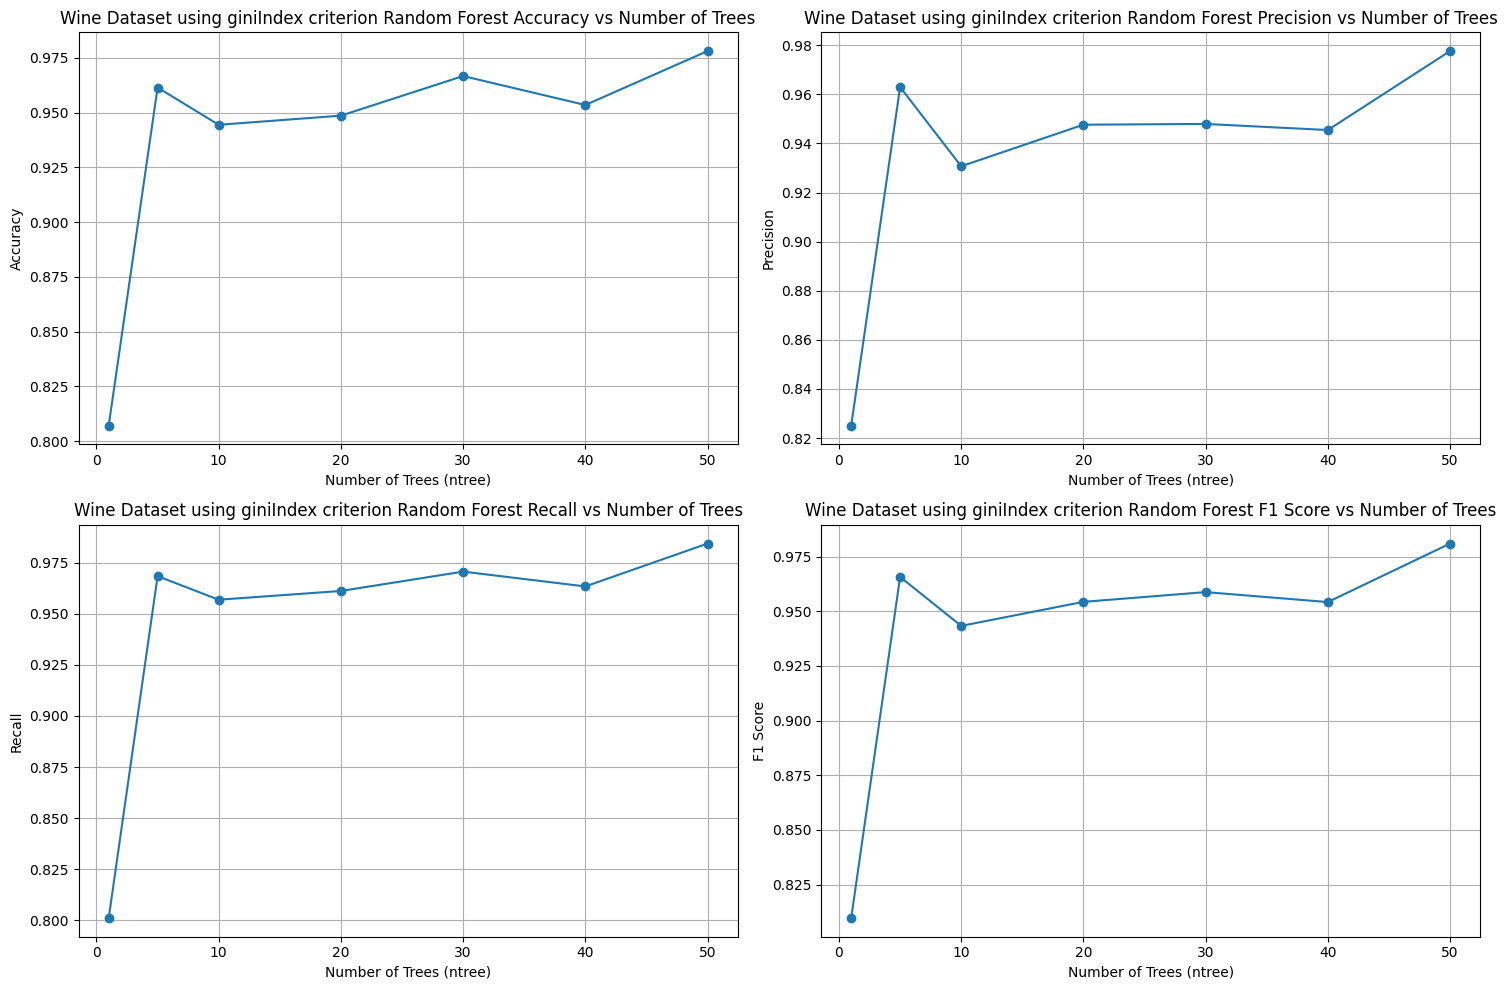

########################### House_Votes_84 DataSet using giniIndex criterion ###########################

************NTree 1************

Accuracy: 0.9268423437028088

Precision: 0.926546167612344

Recall: 0.928250454480301

F1Score: 0.9273187247059699

************NTree 5************

Accuracy: 0.9498389207691533

Precision: 0.9491085462833257

Recall: 0.9443363032652956

F1Score: 0.9466455174058381

************NTree 10************

Accuracy: 0.9424821302728279

Precision: 0.9382983674479288

Recall: 0.9426066933718733

F1Score: 0.9403709860217578

************NTree 20************

Accuracy: 0.961043994764925

Precision: 0.9560558885558885

Recall: 0.9657188430402796

F1Score: 0.9607478112904364

************NTree 30************

Accuracy: 0.9678596597201249

Precision: 0.9648346130850001

Recall: 0.9683254598108603

F1Score: 0.966519021849578

************NTree 40************

Accuracy: 0.9539539917446895

Precision: 0.9485710750259431

Recall: 0.9537230321278309

F1Score: 0.951117

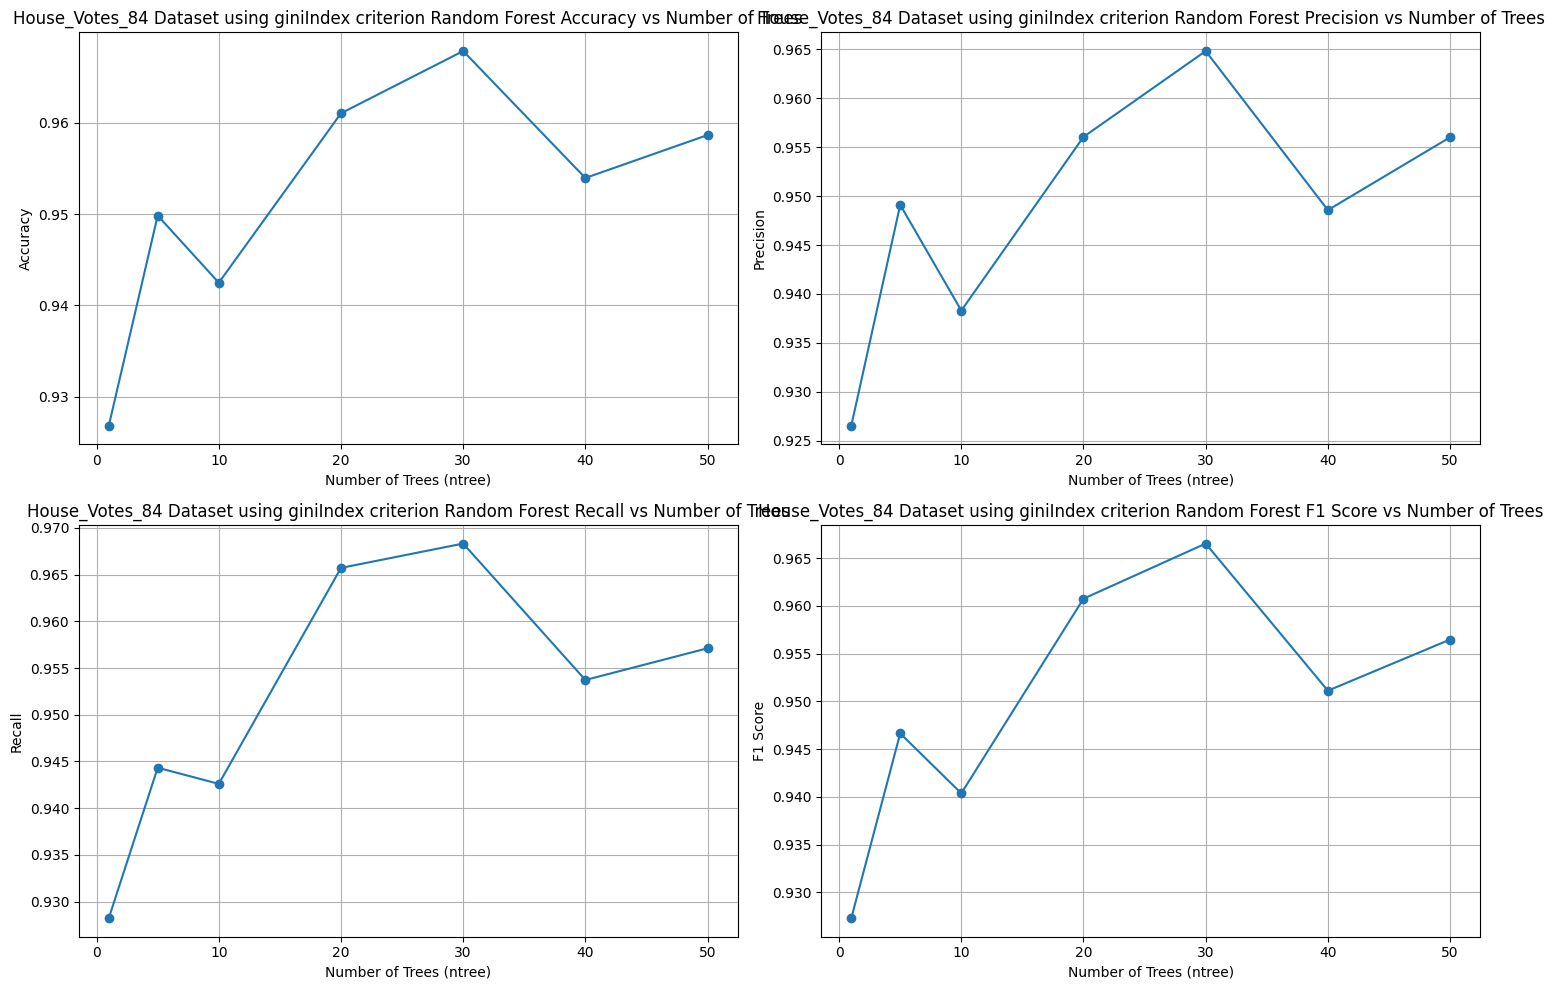

########################### Cancer DataSet using infoGain criterion ###########################

************NTree 1************

Accuracy: 0.8693756449948401

Precision: 0.8584523809523811

Recall: 0.8767424242424244

F1Score: 0.8660331520341144

************NTree 5************

Accuracy: 0.9453216374269005

Precision: 0.9408333333333333

Recall: 0.9512566137566137

F1Score: 0.9459121224926383

************NTree 10************

Accuracy: 0.9777777777777779

Precision: 0.9788492063492065

Recall: 0.9843374218374219

F1Score: 0.9815539882009261

************NTree 20************

Accuracy: 0.97218782249742

Precision: 0.9680555555555556

Recall: 0.9760714285714286

F1Score: 0.9718326660633293

************NTree 30************

Accuracy: 0.9888888888888889

Precision: 0.9833333333333334

Recall: 0.992962962962963

F1Score: 0.9879761512573559

************NTree 40************

Accuracy: 0.988562091503268

Precision: 0.9904761904761905

Recall: 0.9915343915343916

F1Score: 0.991002367797947

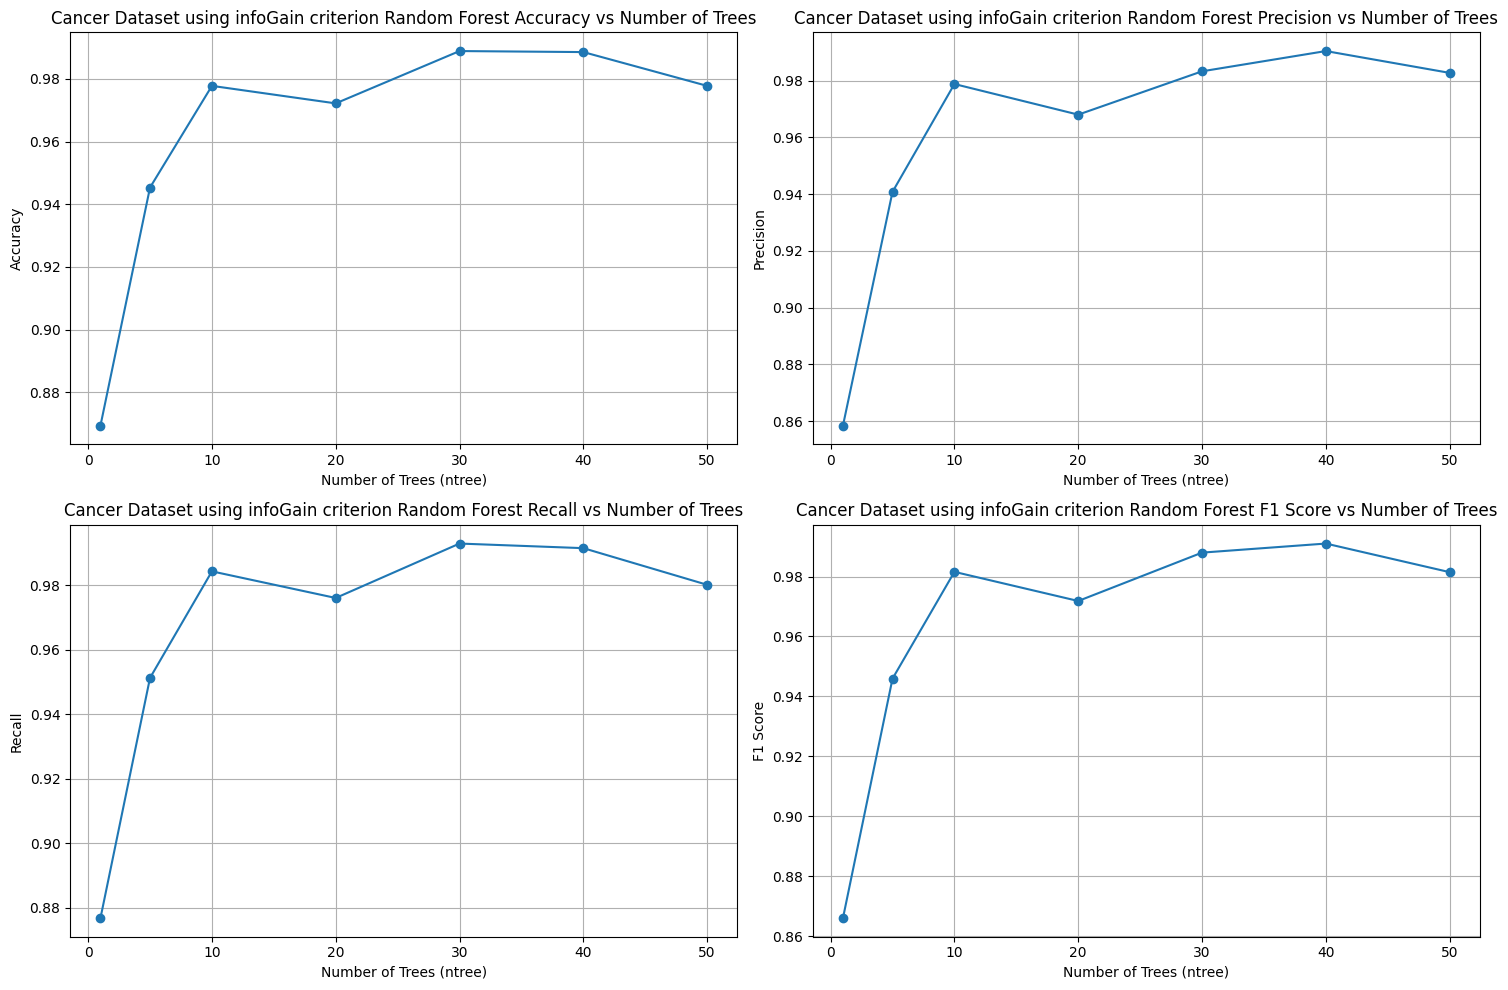

########################### Cancer DataSet using giniIndex criterion ###########################

************NTree 1************

Accuracy: 0.8985955904560556

Precision: 0.8854625629121828

Recall: 0.8993358076177179

F1Score: 0.8922394527714435

************NTree 5************

Accuracy: 0.9518448605657908

Precision: 0.9539559087011412

Recall: 0.9460445608948266

F1Score: 0.9498803452428772

************NTree 10************

Accuracy: 0.9561713480318131

Precision: 0.9534669525402417

Recall: 0.9571073096492689

F1Score: 0.9552343997903654

************NTree 20************

Accuracy: 0.9517341185945837

Precision: 0.9478919954702688

Recall: 0.9500866553855168

F1Score: 0.9489494831209135

************NTree 30************

Accuracy: 0.9563877982482634

Precision: 0.9527690858822886

Recall: 0.9567526010162926

F1Score: 0.9545838038336868

************NTree 40************

Accuracy: 0.9539514748817075

Precision: 0.9487615061043252

Recall: 0.9536759468601576

F1Score: 0.9511237330

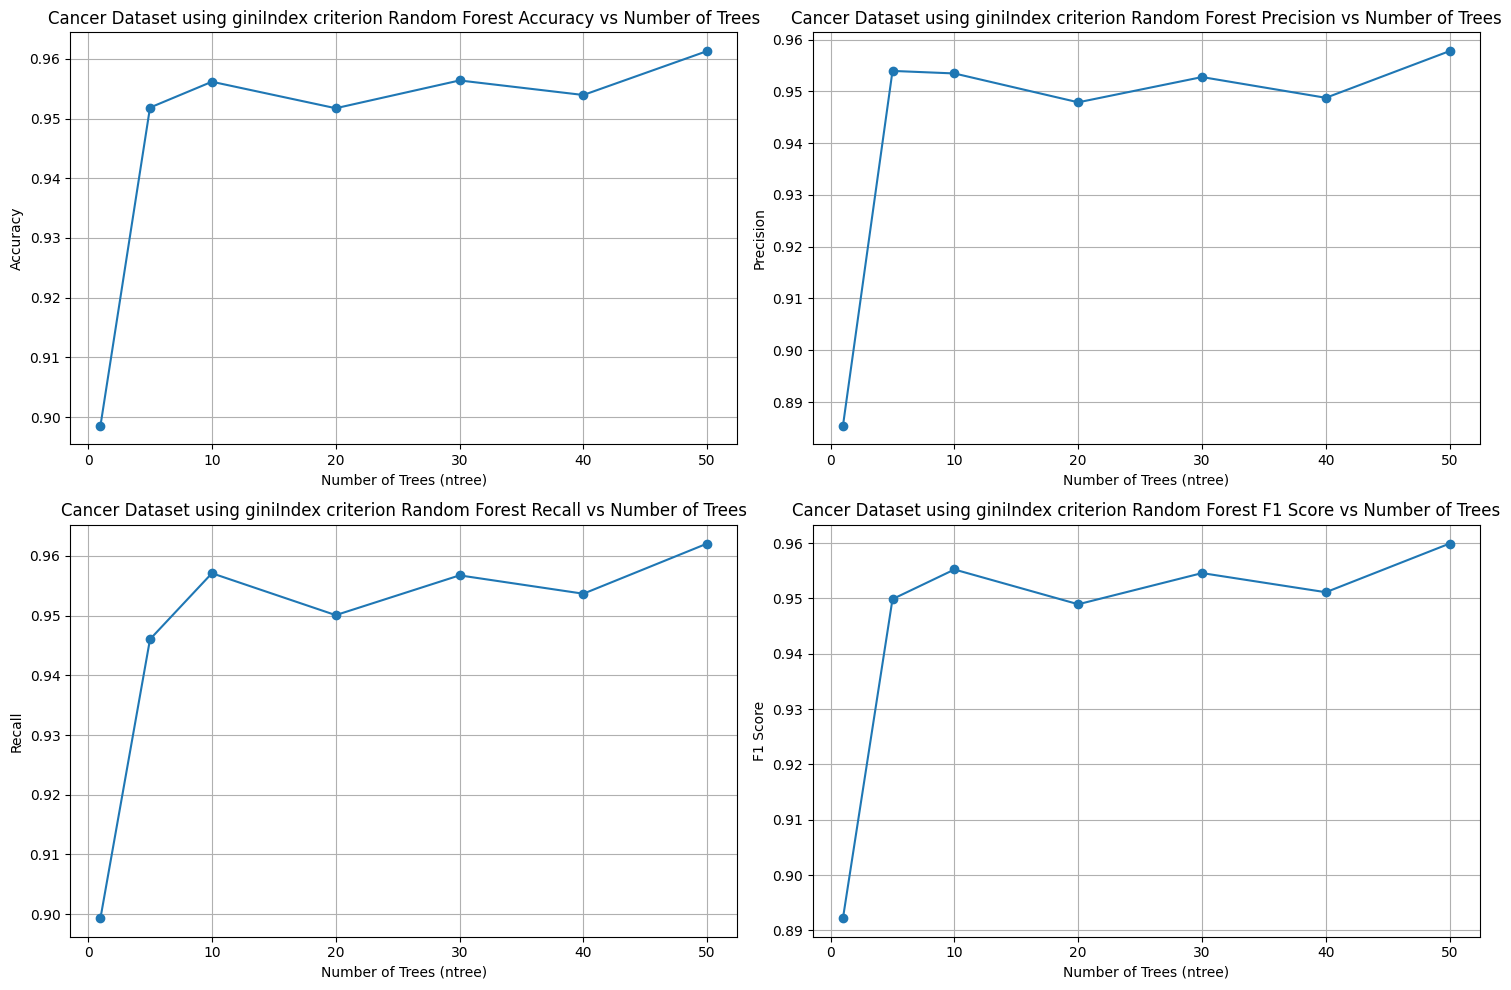

########################### Contraceptive Choice DataSet using infoGain criterion ###########################

************NTree 1************

Accuracy: 0.8697432920536634

Precision: 0.8795370370370371

Recall: 0.8760545935545936

F1Score: 0.8762052163012882

************NTree 5************

Accuracy: 0.961111111111111

Precision: 0.9667724867724867

Recall: 0.9616125541125541

F1Score: 0.9640594736615347

************NTree 10************

Accuracy: 0.9833333333333334

Precision: 0.9863095238095237

Recall: 0.9833333333333334

F1Score: 0.9847953216374268

************NTree 20************

Accuracy: 0.9783625730994153

Precision: 0.9790740740740741

Recall: 0.9784391534391534

F1Score: 0.9786530516620935

************NTree 30************

Accuracy: 0.9891812865497076

Precision: 0.985

Recall: 0.9907407407407408

F1Score: 0.9878100679161687

************NTree 40************

Accuracy: 0.9832989336085312

Precision: 0.9863492063492064

Recall: 0.9813492063492063

F1Score: 0.98366607020

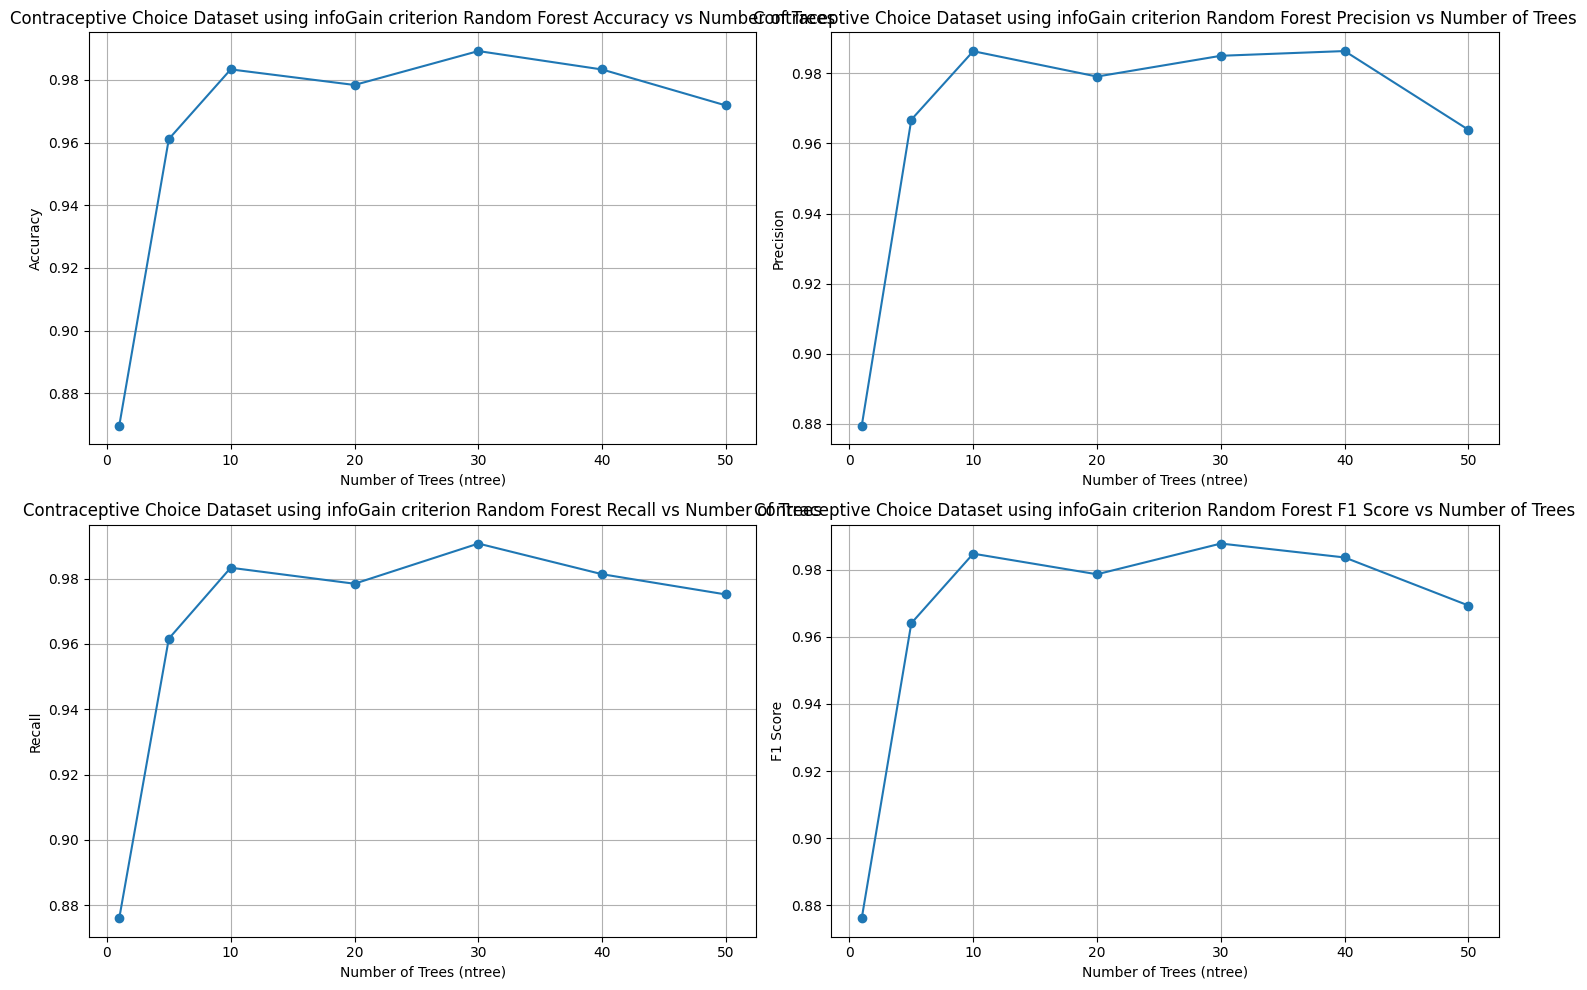

########################### Contraceptive Choice DataSet using giniIndex criterion ###########################

************NTree 1************

Accuracy: 0.924514245444478

Precision: 0.9201039911793727

Recall: 0.9196382920055092

F1Score: 0.9198364012703338

************NTree 5************

Accuracy: 0.9468111346018324

Precision: 0.9455252793183828

Recall: 0.9444087864562001

F1Score: 0.9448855414603615

************NTree 10************

Accuracy: 0.9588769757374409

Precision: 0.956454469507101

Recall: 0.9578875559885789

F1Score: 0.9571503029039949

************NTree 20************

Accuracy: 0.961038961038961

Precision: 0.9553998135388924

Recall: 0.9631337972885963

F1Score: 0.9592138111128936

************NTree 30************

Accuracy: 0.9566067653276956

Precision: 0.9556134727845255

Recall: 0.9562426489632372

F1Score: 0.9558398681388727

************NTree 40************

Accuracy: 0.9587712674921975

Precision: 0.9566795924370552

Recall: 0.9582219207856388

F1Score: 0

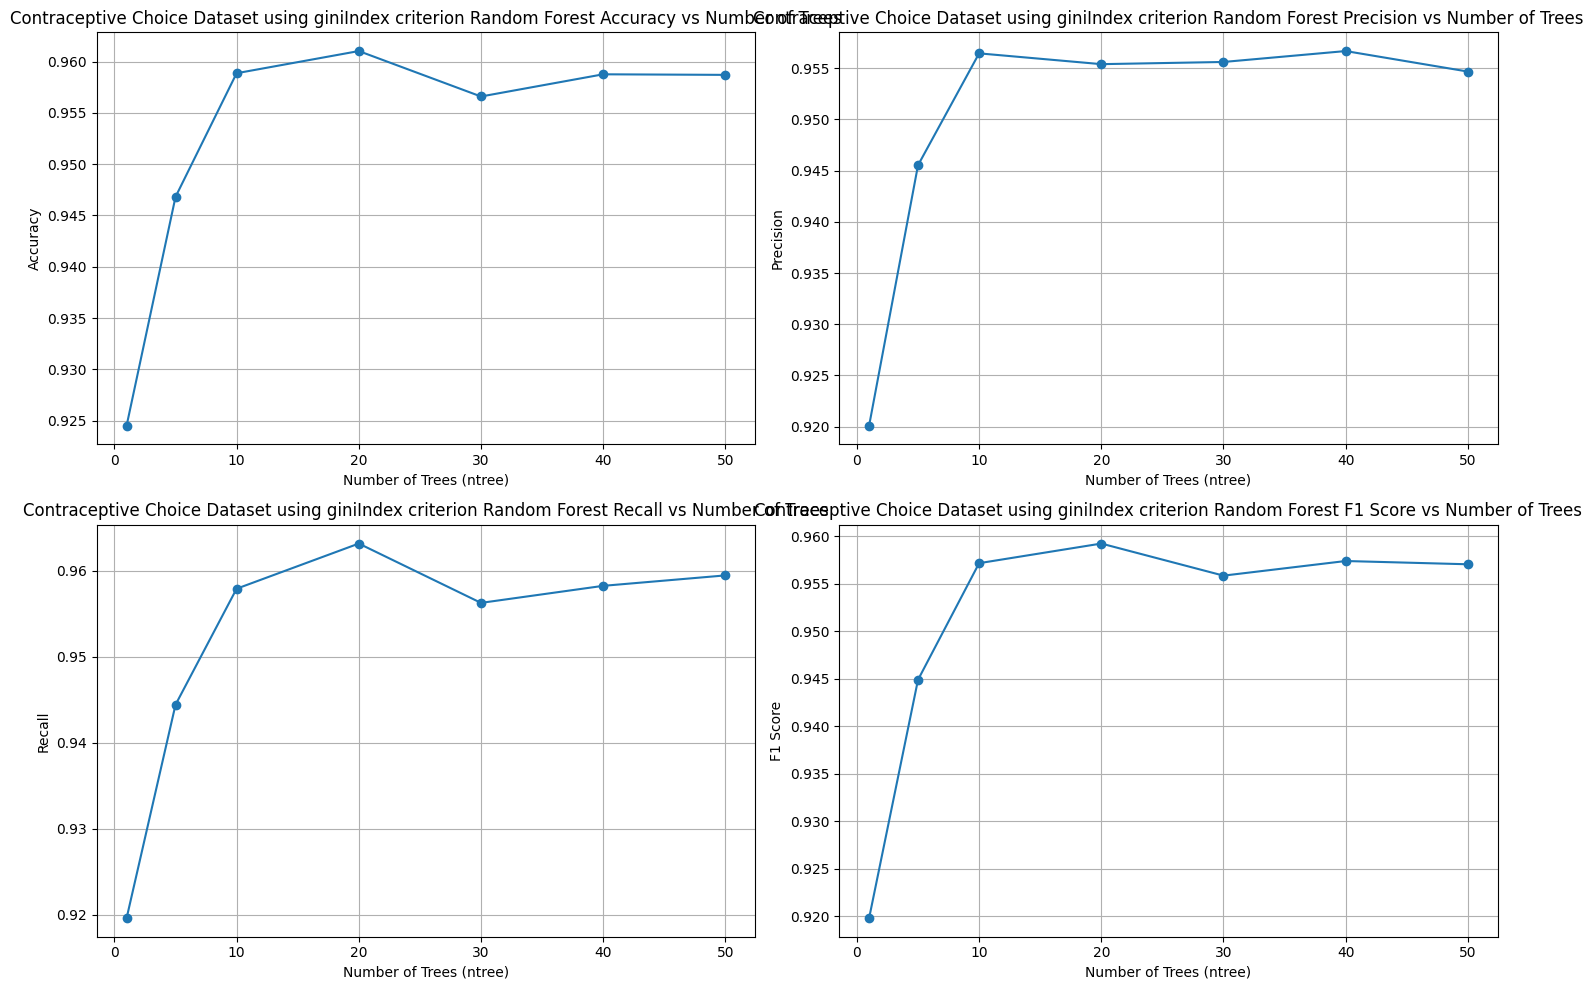

In [72]:
voteDataWine = getWineDataSet()
voteDataHouse = getHouseVoteDataset()
voteDataCance = getCancerDataset()
voteDataContraceptive = getContraceptiveDataSet()
startAlgo(voteDataWine, "Wine", "infoGain")
startAlgo(voteDataHouse, "House_Votes_84", "infoGain")
startAlgo(voteDataWine, "Wine", "giniIndex")
startAlgo(voteDataHouse, "House_Votes_84", "giniIndex")
startAlgo(voteDataWine, "Cancer", "infoGain")
startAlgo(voteDataHouse, "Cancer", "giniIndex")
startAlgo(voteDataWine, "Contraceptive Choice", "infoGain")
startAlgo(voteDataHouse, "Contraceptive Choice", "giniIndex")